# Diving into BoardGameGeek
> 3 Key Insights from 19M reviews

- toc: false
- branch: master
- badges: true
- comments: true
- author: Jesse van Elteren
- image: images/
- categories: []

![](images/bgg.jpg)

If you like boardgames, there is a good chance you are thinking of buying another one. It's a bit of a guilty pleasure in which I also indulge sometimes. Many people turn to [BoardGameGeek (BGG)](https://boardgamegeek.com/), which is a great site with many active users reviewing games. I used the BGG API to download:
* 19M reviews (users giving games a rating)
* 21K games (game type, complexity, minimum age etc)

### The ratings

In [2]:
# hide
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import warnings
from pandas.errors import DtypeWarning

from utils.database import DB

warnings.simplefilter(action='ignore', category=DtypeWarning)
pd.options.display.max_rows = 200

In [43]:
# hide
# # metric for corretlation of categorial features with target. Used for sorting features in displaying


def types(data, y_col):
    # split columns into sorted numerical and categorical based on correlation with y_col
    corr = data.corr()[y_col]
    corr = corr.sort_values(ascending=False)
    num_x = list(corr.index)[1:]

    cat_x = [col for col in data.columns if data[col].dtype == 'object']
    cat_x.sort(key = lambda x: -correlation_ratio(data[x],data[y_col]))
    
    return num_x, cat_x


def split(data, y_col):
    # splits dataset into x and y dataset
    data_x = data.drop([y_col], axis=1)
    data_y = data.loc[:,y_col]
    return data_x, data_y

    
    


def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

def regr(x, y, s=0.01):
    regr = linear_model.LinearRegression()
    x = x.values.reshape(-1, 1)
    regr.fit(x, y)
    print(f'r2: {regr.score(x, y):.2f}')
    # plot it as in the example at http://scikit-learn.org/
    plt.scatter(x, y,  color='black',s=s)
    plt.plot(x, regr.predict(x), color='blue', linewidth=3)
    return plt


In [4]:
# hide
db = DB('bgg2022.db')
df = pd.read_csv('games_detailed_info.csv')
y = 'average'

[('games', 21839), ('reviews', 18964807)]


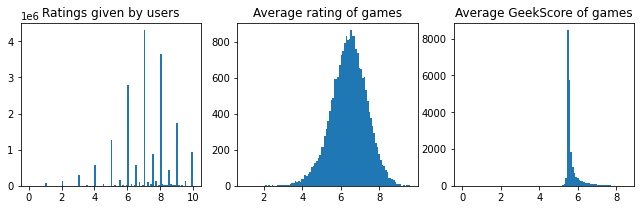

In [5]:
# hide
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(11,3))
ax1.hist(db.df("SELECT rating FROM reviews").astype(float), bins=100)
ax1.title.set_text('Ratings given by users')
ax2.hist(df[y], bins=100)
ax2.title.set_text('Average rating of games')
ax3.hist(df['bayesaverage'], bins=100);
ax3.title.set_text('Average GeekScore of games')

Users give ratings that are rounded, a 8 is more likely than a 8.25, that's why you see the spikes. Looking at the games, we see a nice normal distribution with a mean of 6.4 (for the purists: no I've got no intention of testing for normality here😊).

In addition BGG has it's own Geekscore, which penalizes games with few reviews. You see that distribution is much more 'squashed', with an hardly any games above a 6.

### Ratings over the years

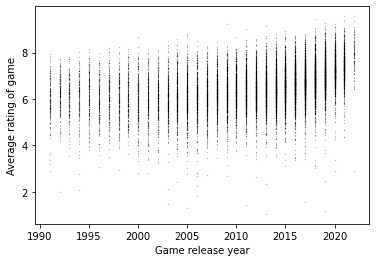

In [6]:
# hide_input
years = df.loc[(df['yearpublished'] > 1990) & (df['yearpublished'] < 2023)]
plt.scatter(years['yearpublished'], years[y],  color='black',s=0.01)
plt.xlabel('Game release year')
plt.ylabel('Average rating of game');

# regr(years['yearpublished'], years['average'], s=0.01);

There seems to be an increase in the scores over the years. Let's plot the averages

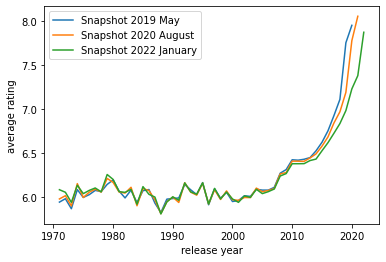

In [7]:
# hide_input
cut = 1970
versions = [('archive/games_detailed_info_2019.csv', 'Snapshot 2019 May'),
            ('archive/games_detailed_info_2020.csv', 'Snapshot 2020 August'),
            ('games_detailed_info.csv', 'Snapshot 2022 January')]
for path, label in versions:
    dfold = pd.read_csv(path)
    df2 = dfold.loc[(dfold['yearpublished'] > cut) & (dfold['yearpublished'] < 2023)]
    yearsold = df2.groupby('yearpublished').agg('mean').reset_index()
    plt.plot(yearsold['yearpublished'], yearsold['average'], label=label)
plt.ylabel('average rating')
plt.xlabel('release year')

plt.legend();

I've downloaded this dataset before, that's why you see 3 lines in this chart.

There are two interesting phenomena here:
* Scores have been climbing since 2000. Maybe people have been more rewarding in their scores, but there is a general consensus that boardgames have improved in quality.
* As you see the 3 snapshots diverge around 2015. I call this the 'shiny new' effect, where the early adopters score a game higher. For a year the blue line scores highest, after the orange and lowest in the most recent version of the dataset. Games from 2020 where rated with 7.8 in 2020, but two years later that has dropped to 7.2 and now games from 2022 are rated with 7.8! When games are about 5 years old the 'new' effect is more or less gone and games reach a stable score (e.g. 2014 there is no difference anymore). 

### Complexity of games and ratings

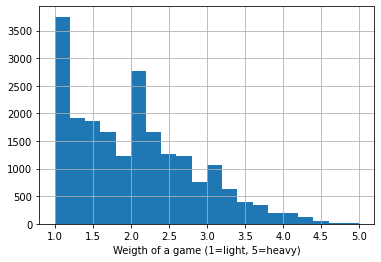

In [8]:
df2 = df.loc[df['averageweight'] > 0]
ax = df2['averageweight'].hist(bins=20)
ax.set_xlabel('Weigth of a game (1=light, 5=heavy)');

For your reference some idea of the weights:
* Monopoly: 1.3
* Catan: 2.3
* Agricola: 3.6

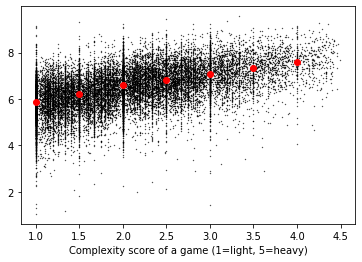

In [40]:
# hide
s = 0.1
ax1 = plt.axes()
ax1.scatter(df2['averageweight'], df2[y],  color='black',s=s)

df2['complexity'] = (df2['averageweight'] // 0.5 * 0.5).copy()
df2 = df2.loc[df2['complexity']<4.5]
complexity = df2.groupby('complexity').agg('mean').reset_index()
ax1.scatter(complexity['complexity'], complexity['average'], color='red')

ax1.set_xlabel('Complexity score of a game (1=light, 5=heavy)');

There is some relation between the weight/complexity of the game and the score. More complex games get higher scores, it's almost a 1 point difference between a game with weight 1 and 5.

### Preprocessing

In [232]:
df = pd.read_csv('games_detailed_info.csv')
from aocutils.datascience import nan_inspect

In [233]:
# drop irrelevant variables

relevant = ['yearpublished', 'minplayers', 'maxplayers',
        'playingtime', 'minplaytime',
       'maxplaytime', 'minage', 'boardgamecategory', 'boardgamemechanic',
       'usersrated', 'average', 'bayesaverage', 'stddev', 'owned',
       'trading', 'wanting', 'wishing', 'numcomments', 'numweights',
       'averageweight']
# maybe for later, now exclude:
# 'suggested_num_players', 'suggested_playerage','suggested_language_dependence',
df = df[relevant]
num_x, cat_x = types(df, 'average')

In [234]:
chars = "[]'\""
# df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_,]+', '', x))

onehot = ['boardgamecategory', 'boardgamemechanic']
for cat in onehot:
    # df[cat] = df[cat].str.replace('[/]+', ",", regex=True)
    df[cat] = df[cat].str.replace('[^A-Za-z0-9_,]+', "", regex=True)
    df[cat] = df[cat].str.replace('[^A-Za-z0-9_,]+', "", regex=True)
    onehotencoded = df[cat].str.get_dummies(sep=',',)
    onehotencoded.fillna(0, inplace=True)
    print(cat, len(onehotencoded.columns))
    df = pd.concat([df.drop(cat, axis=1), onehotencoded], axis=1)
    # some columns like Deduction are duplicated, since they appear in both category and mechanic
    df = df.loc[:,~df.columns.duplicated()]
    
        
  


boardgamecategory 84
boardgamemechanic 185


In [235]:
df[num_x].describe()

,averageweight,bayesaverage,wanting,wishing,minage,numcomments,owned,usersrated,numweights,trading,playingtime,maxplaytime,yearpublished,minplaytime,maxplayers,minplayers,stddev
count,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000
mean,1.978830,5.682452,42.030373,233.655587,9.611391,213.221811,1487.924553,875.000693,50.037030,43.585965,90.509177,90.509177,1986.094910,63.647774,5.709491,2.007027,1.521731
std,0.848984,0.376194,117.940355,800.657809,3.640562,674.130830,5395.077773,3697.681390,207.654901,102.410851,534.826511,534.826511,210.042496,447.213702,15.102385,0.688957,0.289918
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,29.000000,0.000000,0.000000,0.000000,0.000000,-3500.000000,0.000000,0.000000,0.000000,0.196023
25%,1.333300,5.510095,3.000000,14.000000,8.000000,24.000000,150.000000,57.000000,4.000000,5.000000,25.000000,25.000000,2001.000000,20.000000,4.000000,2.000000,1.324405
50%,1.952400,5.545960,9.000000,39.000000,10.000000,51.000000,322.000000,124.000000,9.000000,13.000000,45.000000,45.000000,2011.000000,30.000000,4.000000,2.000000,1.480940
75%,2.520000,5.677695,29.000000,131.000000,12.000000,138.000000,903.500000,397.000000,26.000000,38.000000,90.000000,90.000000,2017.000000,60.000000,6.000000,2.000000,1.669205
max,5.000000,8.510550,2011.000000,19325.000000,25.000000,19402.000000,168364.000000,109006.000000,7690.000000,2508.000000,60000.000000,60000.000000,2023.000000,60000.000000,999.000000,10.000000,4.277280


In [236]:
df[num_x].describe()

,averageweight,bayesaverage,wanting,wishing,minage,numcomments,owned,usersrated,numweights,trading,playingtime,maxplaytime,yearpublished,minplaytime,maxplayers,minplayers,stddev
count,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000
mean,1.978830,5.682452,42.030373,233.655587,9.611391,213.221811,1487.924553,875.000693,50.037030,43.585965,90.509177,90.509177,1986.094910,63.647774,5.709491,2.007027,1.521731
std,0.848984,0.376194,117.940355,800.657809,3.640562,674.130830,5395.077773,3697.681390,207.654901,102.410851,534.826511,534.826511,210.042496,447.213702,15.102385,0.688957,0.289918
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,29.000000,0.000000,0.000000,0.000000,0.000000,-3500.000000,0.000000,0.000000,0.000000,0.196023
25%,1.333300,5.510095,3.000000,14.000000,8.000000,24.000000,150.000000,57.000000,4.000000,5.000000,25.000000,25.000000,2001.000000,20.000000,4.000000,2.000000,1.324405
50%,1.952400,5.545960,9.000000,39.000000,10.000000,51.000000,322.000000,124.000000,9.000000,13.000000,45.000000,45.000000,2011.000000,30.000000,4.000000,2.000000,1.480940
75%,2.520000,5.677695,29.000000,131.000000,12.000000,138.000000,903.500000,397.000000,26.000000,38.000000,90.000000,90.000000,2017.000000,60.000000,6.000000,2.000000,1.669205
max,5.000000,8.510550,2011.000000,19325.000000,25.000000,19402.000000,168364.000000,109006.000000,7690.000000,2508.000000,60000.000000,60000.000000,2023.000000,60000.000000,999.000000,10.000000,4.277280


### Training

In [241]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)
x, y = split(train, 'average')
x_test, y_test = split(test, 'average')
len(df), len(train), len(test)


(21631, 17304, 4327)

In [242]:
from dataclasses import dataclass
import lightgbm as lgb

model = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.01, n_estimators=1000,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11,random_state=112)
model = model.fit(x,y)


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [243]:
model.score(x_test,y_test)

0.835101135440095

## Exploration: Quantitative Variables

In [ ]:
path_train = 'games_detailed_info.csv'
num_x = eda.num_x
import altair as alt
from altair.expr import datum
def gen_chart(name):
    return alt.Chart(path_train).mark_point(
        color='red',
        opacity=0.1,
        size=1
    ).encode(
        x= alt.X(name+':Q',scale=alt.Scale(zero=False)) ,
        y='average:Q'
    ).properties(
        width=150,
        height=150
    )

#create a list of subplots
subplts = []
for name in num_x:
    subplts.append(gen_chart(name))
plots_per_row = 7
hconcat = [alt.hconcat(*subplts[i:i+plots_per_row]) for i in range(0, len(subplts), plots_per_row)]
alt.vconcat(*hconcat)

alt.VConcatChart(...)

## Exploration: Quantitative Variables interactive chart

In [ ]:
import altair as alt
brush = alt.selection(type='interval', resolve='global')

base = alt.Chart(path_train).mark_point(        opacity=0.1,
        size=2).encode(
    y='average:Q',
    color=alt.condition(brush, alt.ColorValue('red'), alt.ColorValue('gray')),
).add_selection(
    brush
).properties(
    width=140,
    height=140
)
num_x.append('average')
subplts = []
for name in num_x:
    subplts.append(base.encode(alt.X(name+':Q',scale=alt.Scale(zero=False))))
plots_per_row = 7
hconcat = [alt.hconcat(*subplts[i:i+plots_per_row]) for i in range(0, len(subplts), plots_per_row)]
alt.vconcat(*hconcat)

alt.VConcatChart(...)

In [ ]:
## Exploration: Categorical Variables

In [ ]:
cat_x = eda.cat_x
def gen_chart(name):
  chart = alt.Chart(path_train).mark_bar().encode(
        x= alt.X(name+':N', bin=False),
        y='count()',
        color=alt.condition(brush, alt.ColorValue('red'), alt.ColorValue('gray'))
    ).properties(
        width=140,
        height=30
    ).add_selection(
    brush)

  price = alt.Chart(path_train).mark_boxplot().encode(
        x= alt.X(name+':N'),
        y='SalePrice:Q',
        color=alt.condition(brush, alt.ColorValue('red'), alt.ColorValue('gray'))
    ).properties(
        width=140,
        height=140
    ).add_selection(
    brush)
  return price & chart

brush = alt.selection(type='interval', resolve='global')
#create a list of subplots
subplts = []
for name in cat_x:
    subplts.append(gen_chart(name))
plots_per_row = 7
hconcat = [alt.hconcat(*subplts[i:i+plots_per_row]) for i in range(0, len(subplts), plots_per_row)]
alt.vconcat(*hconcat)

alt.VConcatChart(...)

In [ ]:
train_x['YearBuilt'].describe()

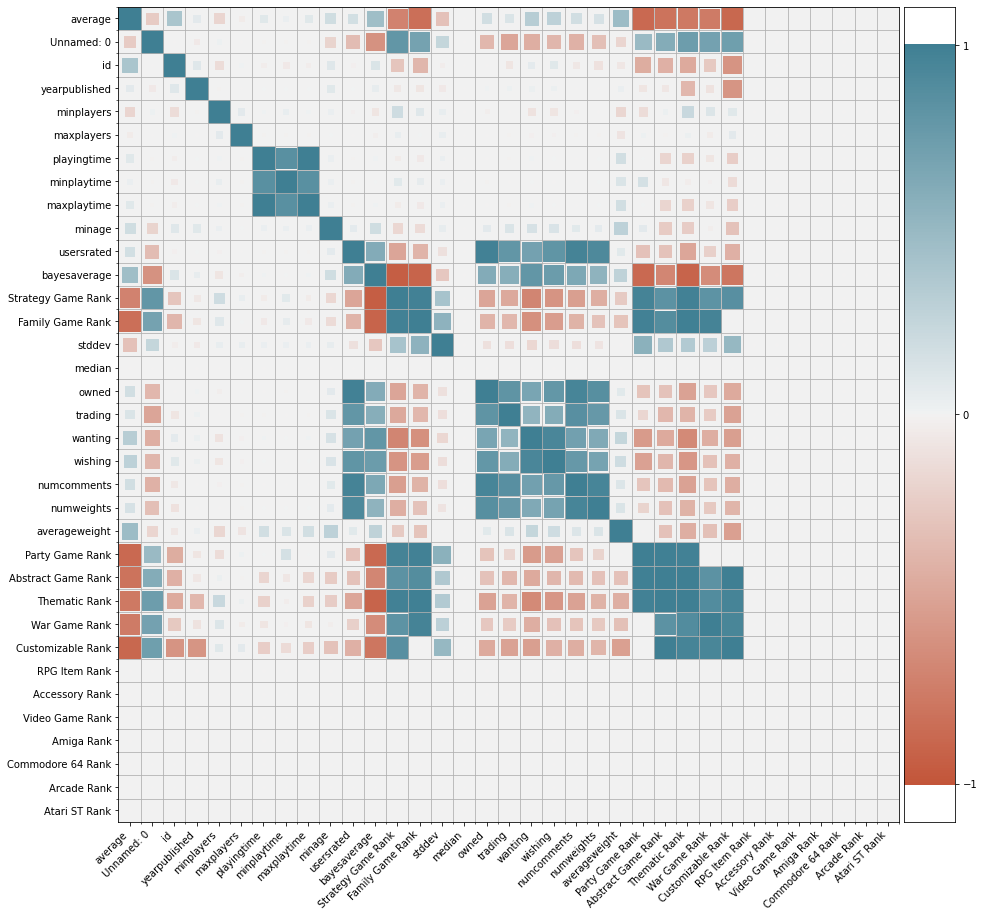

In [ ]:
# pip install heatmapz
import heatmap
from heatmap import heatmap, corrplot
from matplotlib import pyplot as plt

plt.figure(figsize=(15, 15))
corrplot(pd.concat([eda.data_y,eda.data_x],axis=1).corr())

In [ ]:
# check how nan values are correlated
from aocutils.datascience import nan_inspect
import altair as alt
df = nan_inspect(df).reset_index()
df = df.melt('index', var_name='to', value_name='corr')
plt.figure(figsize=(15, 15))
alt.Chart(df).mark_rect().encode(
    x=alt.X('index:O',sort=alt.EncodingSortField(field="corr", op="sum", order='descending')),
    y=alt.Y('to:O',sort=alt.EncodingSortField(field="corr", op="sum", order='descending')),
    color='corr:Q'
)

15     376
14      73
16    1082
13       6
17    2366
18    4023
19    5236
20    4670
21    2591
22     945
23     231
24      31
26       1
dtype: int64


alt.Chart(...)

<Figure size 1080x1080 with 0 Axes>